# **Import Library**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import shap

# **Load Data**





In [34]:
from google.colab import drive
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Tentukan path folder yang sesuai setelah Drive di-mount
folder_path = '/content/drive/MyDrive/home_credit/'

# Membaca file Parquet
app_train = pd.read_parquet(f'{folder_path}application_train_cleaned.parquet')
bb = pd.read_parquet(f'{folder_path}bureau_balance.parquet')
bureau = pd.read_parquet(f'{folder_path}bureau_cleaned.parquet')
ccb = pd.read_parquet(f'{folder_path}credit_card_balance.parquet')
ipayment = pd.read_parquet(f'{folder_path}installments_payments.parquet')
pos_cash = pd.read_parquet(f'{folder_path}pc_balance.parquet')
prev_app = pd.read_parquet(f'{folder_path}prev_app.parquet')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Feature Engineering dan Join Data**

### **Agregasi Bureau dan Bureau Balance**

In [35]:
bb

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0.0,C
1,5715448,-1.0,C
2,5715448,-2.0,C
3,5715448,-3.0,C
4,5715448,-4.0,C
...,...,...,...
1144095,5713858,-37.0,X
1144096,5713858,-38.0,0
1144097,5713858,-39.0,X
1144098,5713858,-40.0,X


In [36]:
print(bb['MONTHS_BALANCE'].value_counts(), bb['STATUS'].value_counts())

MONTHS_BALANCE
-1.0     27323
-2.0     27122
-3.0     26933
 0.0     26745
-4.0     26663
         ...  
-92.0     2125
-93.0     1972
-94.0     1841
-95.0     1724
-96.0     1601
Name: count, Length: 97, dtype: int64 STATUS
C    560796
0    320146
X    248642
1     10176
5      2721
2      1035
3       347
4       236
Name: count, dtype: int64


In [37]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,0,91323.00,0.0,0.0,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,-897.0,0,225000.00,171342.0,0.0,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,-897.0,0,464323.50,0.0,0.0,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,0.0,-897.0,0,90000.00,0.0,0.0,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,-897.0,0,2700000.00,0.0,0.0,0.0,Consumer credit,-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,-897.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,0,15570.00,0.0,0.0,0.0,Consumer credit,-967
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508


TARGET                  0      1
STATUS_BIN                      
sangat terlambat   239054  20038
sedikit terlambat     913    122
terlambat            3083    206
tidak terlambat        73      2


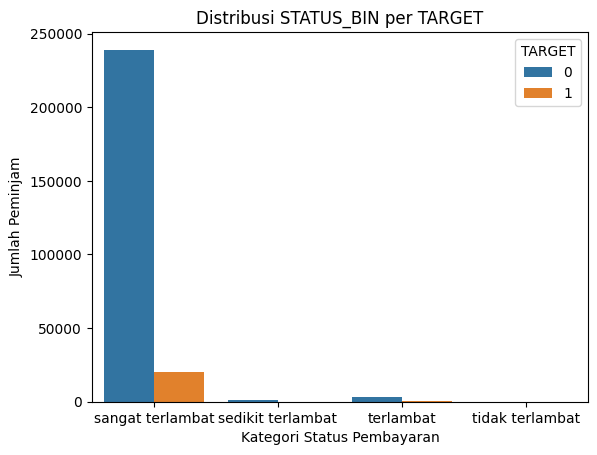

In [38]:
# 1. Menggabungkan dan menghitung exposure total jumlah pinjaman kredit yg pernah atau sedang di pinjam dan total jumlah pinjaman yg belum dibayar
bureau_agg = bureau.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

# 2. Mapping status ke skor numerik
status_mapping = {'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}
bb['STATUS_NUM'] = bb['STATUS'].map(status_mapping)

# 3. Hitung rata-rata skor status per SK_ID_BUREAU lalu gabungkan ke bureau
bb_status = bb.groupby('SK_ID_BUREAU')['STATUS_NUM'].mean().reset_index(name='AVG_BUREAU_STATUS')
bureau_status = bureau.merge(bb_status, on='SK_ID_BUREAU', how='left')

# 4. Hitung rata-rata per SK_ID_CURR
status_by_curr = bureau_status.groupby('SK_ID_CURR')['AVG_BUREAU_STATUS'].mean().reset_index()

# 5. tambahkan status BIN (kategori)
def bin_status(n):
  if n == 0:
    return 'tidak terlambat'
  elif n >= 1:
    return 'sedikit terlambat'
  elif n <= 3:
    return 'terlambat'
  else:
    return 'sangat terlambat'

status_by_curr['STATUS_BIN'] = status_by_curr['AVG_BUREAU_STATUS'].apply(bin_status)

# 6. Hitung rata-rata hari keterlambatan pinjaman
avg_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index(name='AVG_DAY_OVERDUE')

# 7. Gabungkan fitur-fitur yg diseleksi ke app_train
app_train_enriched = app_train.copy()
app_train_enriched = app_train_enriched.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_train_enriched = app_train_enriched.merge(status_by_curr[['SK_ID_CURR', 'AVG_BUREAU_STATUS', 'STATUS_BIN']], on='SK_ID_CURR', how='left')
app_train_enriched = app_train_enriched.merge(avg_overdue, on='SK_ID_CURR', how='left')

# Handle missing value
app_train_enriched[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AVG_BUREAU_STATUS', 'AVG_DAY_OVERDUE']] = \
    app_train_enriched[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AVG_BUREAU_STATUS', 'AVG_DAY_OVERDUE']].fillna(0)

# Tambahkan fitur rasio utang/pinjaman
app_train_enriched['DEBT_CREDIT_RATIO'] = app_train_enriched['AMT_CREDIT_SUM_DEBT'] / \
                                          app_train_enriched['AMT_CREDIT_SUM'].replace(0, 1)

# Analisis dan visualisasi
print(app_train_enriched.groupby(['STATUS_BIN', 'TARGET']).size().unstack(fill_value=0))

sns.countplot(data=app_train_enriched, x='STATUS_BIN', hue='TARGET')
plt.title('Distribusi STATUS_BIN per TARGET')
plt.xlabel('Kategori Status Pembayaran')
plt.ylabel('Jumlah Peminjam')
plt.show()

In [39]:
app_train_enriched

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AVG_BUREAU_STATUS,STATUS_BIN,AVG_DAY_OVERDUE,DEBT_CREDIT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,0.0,sangat terlambat,0.0,0.284122
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.0,sangat terlambat,0.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,189037.800,0.00,0.0,sangat terlambat,0.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.00,0.0,NaN,0.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,146250.000,0.00,0.0,sangat terlambat,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.535276,0.9876,0.6042,0.9782,0.4583,0.9876,0.6042,0.2898,No,0.0,0.0,0.0,0.0,-273.0,0.0,0.0,0.0,0.0,0.0,1

AMT_CREDIT_SUM: total jumlah pinjaman kredit yang pernah dimiliki customer dan atau yang masih aktif -> menunjukkan exposure kredit customer (biasanya semakin besar kreditnya semakin dipercaya, tetapi bisa juga beban hutang tinggi)

AMT_CREDIT_SUM_DEBT: total pinjaman/kredit yang belum dibayar (hutang) -> jika nominalnya tinggi ada potensi default

AVG_BUREAU_STATUS: rata-rata status keterlambatan pinjaman -> semakin tinggi skornya semakin berpotensi default dan sangat mempengaruhi fitur prediktif

AVG_DAY_OVERDUE: rata-rata jumlah hari keterlambatan pembayaran -> semakin tinggi nilainya, semakin besar risiko menunda pembayaran kredit berikutnya dan dapat berpotensi default

### **Agregasi Payment Installments dan Join Previous Application**

In [40]:
ipayment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [41]:
# Agregasi data pembayaran dan cicilan
ipayment_agg = ipayment.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Menghitung selisih antara jumlah cicilan dan jumlah yang dibayarkan
ipayment_agg['DIFF_INSTALLMENT_PAYMENT'] = ipayment_agg['AMT_INSTALMENT'] - ipayment_agg['AMT_PAYMENT']

# Menghapus kolom SK_ID_CURR setelah agregasi
ipayment_agg = ipayment_agg.drop(columns='SK_ID_CURR', axis=1)

# Menggabungkan fitur jumlah yang dibayarkan dan jumlah cicilan dari ipayment dengan previous_application
prev_ipayment = pd.merge(prev_app, ipayment_agg, on='SK_ID_PREV', how='left')

In [42]:
prev_ipayment

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,XAP,Approved,-73,Cash through the bank,XAP,Unknown,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,NaN,NaN,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,Y,1,0.000000,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,125943.075,125943.075,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,Y,1,0.000000,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,135546.615,135546.615,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,Y,1,0.000000,XNA,Approved,-512,Cash through the bank,XAP,Unknown,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,563133.375,563133.375,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,Y,1,0.000000,Repairs,Refused,-781,Cash through the bank,HC,Unknown,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,XAP,Approved,-544,Cash through the bank,XAP,Unknown,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,NaN,NaN,NaN
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,NaN,NaN,NaN
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,NaN,NaN,NaN
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,Y,1,0.000000,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,NaN,NaN,NaN


In [43]:
# Memeriksa baris duplikat
duplicate_rows = prev_ipayment.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(prev_ipayment):
    # Hitung nilai null
    null_values = prev_ipayment.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / prev_ipayment.shape[0]) * 100
    nvc["Data Type"] = [prev_ipayment[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_ipayment)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AMT_INSTALMENT,1287599,77.091858,float64
AMT_PAYMENT,1287599,77.091858,float64
DIFF_INSTALLMENT_PAYMENT,1287599,77.091858,float64


AMT_INSTALMENT, AMT_PAYMENT, dan DIFF_INSTALLMENT_PAYMENT memiliki jumlah dan persentase missing value yang sama. secara interpretasi sangat masuk akal jika data tersebut missing karena SK_PREV_ID di data ipayment_agg tidak semuanya ada di prev_app atau artinya customer di aplikasi tidak memiliki cicilan sebelumnya. maka dari itu untuk handle missing value saya buat 0 untuk data missing nya.

In [44]:
# Isi missing values dengan 0
prev_ipayment['AMT_INSTALMENT'].fillna(0, inplace=True)
prev_ipayment['AMT_PAYMENT'].fillna(0, inplace=True)
prev_ipayment['DIFF_INSTALLMENT_PAYMENT'].fillna(0, inplace=True)

In [45]:
# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(prev_ipayment)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

,Total Null Values,Percentage,Data Type


### **Agregasi Credit Card Balance**

In [46]:
ccb

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907.0,-6.0,56.970,135000.0,0.0,877.5,0.0,877.5,1700.325,1800.000,1800.0,0.000,0.000,0.000,0.0,1.0,0.0,1.0,35.0,Active,0.0,0.0
1,2582071,363914.0,-1.0,63975.555,45000.0,2250.0,2250.0,0.0,0.0,2250.000,2250.000,2250.0,60175.080,64875.555,64875.555,1.0,1.0,0.0,0.0,69.0,Active,0.0,0.0
2,1740877,371185.0,-7.0,31815.225,450000.0,0.0,0.0,0.0,0.0,2250.000,2250.000,2250.0,26926.425,31460.085,31460.085,0.0,0.0,0.0,0.0,30.0,Active,0.0,0.0
3,1389973,337855.0,-4.0,236572.110,225000.0,2250.0,2250.0,0.0,0.0,11795.760,11925.000,11925.0,224949.285,233048.970,233048.970,1.0,1.0,0.0,0.0,10.0,Active,0.0,0.0
4,1891521,126868.0,-1.0,453919.455,450000.0,0.0,11547.0,0.0,11547.0,22924.890,27000.000,27000.0,443044.395,453919.455,453919.455,0.0,1.0,0.0,1.0,101.0,Active,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345064,2341449,278461.0,-7.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,314.505,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,40.0,Active,0.0,0.0
1345065,2743495,456248.0,-5.0,0.000,900000.0,0.0,0.0,0.0,0.0,0.000,2554.065,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,Active,0.0,0.0
1345066,2199047,418401.0,-4.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,2554.065,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,Active,0.0,0.0
1345067,1652945,372380.0,-2.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,8.0,Completed,0.0,0.0


In [47]:
# cek kolom numerik dengan nilai terbanyak
n = (ccb.select_dtypes(include='number') > 0).sum()
print(n)

SK_ID_PREV                    1345069
SK_ID_CURR                    1345069
MONTHS_BALANCE                      0
AMT_BALANCE                    575373
AMT_CREDIT_LIMIT_ACTUAL       1080132
AMT_DRAWINGS_ATM_CURRENT       142779
AMT_DRAWINGS_CURRENT           205888
AMT_DRAWINGS_OTHER_CURRENT       4272
AMT_DRAWINGS_POS_CURRENT        85599
AMT_INST_MIN_REGULARITY        553169
AMT_PAYMENT_CURRENT           1205421
AMT_PAYMENT_TOTAL_CURRENT      579752
AMT_RECEIVABLE_PRINCIPAL       528120
AMT_RECIVABLE                  553691
AMT_TOTAL_RECEIVABLE           553753
CNT_DRAWINGS_ATM_CURRENT       142779
CNT_DRAWINGS_CURRENT           203631
CNT_DRAWINGS_OTHER_CURRENT       4451
CNT_DRAWINGS_POS_CURRENT        85599
CNT_INSTALMENT_MATURE_CUM     1132205
SK_DPD                          52937
SK_DPD_DEF                      31224
dtype: int64


Saya akan memilih dan mengagregasikan fitur fitur credit_card_balance berdasarkan data yang terisi banyak (lebih dari 0).

In [48]:
ccb_agg = ccb.groupby('SK_ID_CURR')[['AMT_BALANCE',
                                     'AMT_PAYMENT_TOTAL_CURRENT',
                                     'AMT_CREDIT_LIMIT_ACTUAL',
                                     'AMT_PAYMENT_CURRENT',
                                     'CNT_DRAWINGS_ATM_CURRENT',
                                     'CNT_DRAWINGS_POS_CURRENT',
                                     'CNT_INSTALMENT_MATURE_CUM']].sum().reset_index()

# Pastikan SK_ID_PREV tidak terbawa:
if 'SK_ID_PREV' in ccb_agg.columns:
    ccb_agg.drop('SK_ID_PREV', axis=1, inplace=True)

# Tambahkan/gabungkan fitur-fitur dari dataset ccb ini ke dataset utama app_train_enriched
app_train_enriched = app_train_enriched.merge(ccb_agg, on='SK_ID_CURR', how='left', suffixes=('', '_CCB'))

In [49]:
app_train_enriched

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AVG_BUREAU_STATUS,STATUS_BIN,AVG_DAY_OVERDUE,DEBT_CREDIT_RATIO,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AMT_CREDIT_LIMIT_ACTUAL,AMT_PAYMENT_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,0.0,sangat terlambat,0.0,0.284122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.0,sangat terlambat,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,189037.800,0.00,0.0,sangat terlambat,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.00,0.0,NaN,0.0,0.000000,0.0,0.0,810000.0,7662.195,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0688,No,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,146250.000,0.00,0.0,sangat terlambat,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash l

In [50]:
# Memeriksa baris duplikat
duplicate_rows = app_train_enriched.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(app_train_enriched):
    # Hitung nilai null
    null_values = app_train_enriched.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / app_train_enriched.shape[0]) * 100
    nvc["Data Type"] = [app_train_enriched[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(app_train_enriched)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AMT_BALANCE,223062,72.537893,float64
AMT_PAYMENT_TOTAL_CURRENT,223062,72.537893,float64
AMT_CREDIT_LIMIT_ACTUAL,223062,72.537893,float64
AMT_PAYMENT_CURRENT,223062,72.537893,float64
CNT_DRAWINGS_ATM_CURRENT,223062,72.537893,float64
CNT_DRAWINGS_POS_CURRENT,223062,72.537893,float64
CNT_INSTALMENT_MATURE_CUM,223062,72.537893,float64
STATUS_BIN,44020,14.314935,object


In [53]:
# Handle missing value
cols_to_fill = ['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_CREDIT_LIMIT_ACTUAL',
                'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
                'CNT_INSTALMENT_MATURE_CUM']
app_train_enriched[cols_to_fill] = app_train_enriched[cols_to_fill].fillna(0)

styled_result = check_nan(app_train_enriched)
styled_result

,Total Null Values,Percentage,Data Type
STATUS_BIN,44020,14.314935,object


Untuk mengisi missing value pada kolom tersebut saya berikan nilai 0, karena interpretasinya bahwa sekitar 72% customer pada app_train_enriched tidak punya data credit

In [55]:
# Karena kolom tersebut adalah kategori, saya terapkan lagi fungsi skoringnya
app_train_enriched['STATUS_BIN'] = app_train_enriched['AVG_BUREAU_STATUS'].apply(bin_status)

styled_result = check_nan(app_train_enriched)
styled_result

,Total Null Values,Percentage,Data Type


### **Agregasi Posh Cash**

In [56]:
pos_cash

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0.0,0.0
1,1715348,367990,-33,36.0,35.0,Active,0.0,0.0
2,1784872,397406,-32,12.0,9.0,Active,0.0,0.0
3,1903291,269225,-35,48.0,42.0,Active,0.0,0.0
4,2341044,334279,-35,36.0,35.0,Active,0.0,0.0
...,...,...,...,...,...,...,...,...
6648644,1226422,149447,-6,12.0,8.0,Active,0.0,0.0
6648645,1724014,308641,-15,24.0,19.0,Active,0.0,0.0
6648646,2022919,348700,-11,10.0,9.0,Active,0.0,0.0
6648647,2424168,259258,-6,12.0,10.0,Active,0.0,0.0


In [59]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='avg_dpd')

# Gabungkan ke prev_ipayment
prev_pc = pd.merge(prev_ipayment, pc_agg, on='SK_ID_PREV', how='left')
prev_pc

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,avg_dpd
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,XAP,Approved,-73,Cash through the bank,XAP,Unknown,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.000,0.000,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,Y,1,0.000000,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,125943.075,125943.075,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,Y,1,0.000000,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,135546.615,135546.615,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,Y,1,0.000000,XNA,Approved,-512,Cash through the bank,XAP,Unknown,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,563133.375,563133.375,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,Y,1,0.000000,Repairs,Refused,-781,Cash through the bank,HC,Unknown,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,XAP,Approved,-544,Cash through the bank,XAP,Unknown,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,0.000,0.000,0.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,0.000,0.000,0.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,0.000,0.000,0.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,Y,1,0.000000,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,0.000,0.000,0.0,0.0


In [60]:
styled_result = check_nan(prev_pc)
styled_result

,Total Null Values,Percentage,Data Type
avg_dpd,799533,47.870093,float64


Terdapat 47% missing value pada kolom avg_dpd, ini masuk akal karena tidak semua customer dari prev_ipayment punya catatan/data di pos_cash (karena pos_cash biasanya hanya mencatat kredit berbasis pembelian di toko)

In [61]:
# Handle missing value dengan mean
prev_pc['avg_dpd'].fillna(prev_pc['avg_dpd'].mean(), inplace=True)

styled_result = check_nan(prev_pc)
styled_result

,Total Null Values,Percentage,Data Type


### **Train Full**

In [62]:
# Gabungkan ke app_train_enriched
df_train_full= pd.merge(app_train_enriched, prev_pc, on='SK_ID_CURR', how='left')
df_train_full

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AVG_BUREAU_STATUS,STATUS_BIN,AVG_DAY_OVERDUE,DEBT_CREDIT_RATIO,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AMT_CREDIT_LIMIT_ACTUAL,AMT_PAYMENT_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_y,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,avg_dpd
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,865055.565,245781.00,0.0,tidak terlambat,0.0,0.284122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9.0,Y,1.0,0.000000,XAP,Approved,-606.0,XNA,XAP,Unknown,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0,219625.695,219625.695,0.0,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.0,tidak terlambat,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1810518.0,Cash loans,98356.995,900000.0,1035882.0,0.0,900000.0,FRIDAY,12.0,Y,1.0,0.000000,XNA,Approved,-746.0,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0,1150977.330,1150977.330,0.0,0.000000
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1017400.500,0.00,0.0,tidak terlam

In [68]:
df_train_full.to_parquet(
    'df_train_full.parquet',
    engine='pyarrow',
    index=False,
    compression='snappy'  # Kompresi cepat & umum, tetap jaga presisi
)

In [69]:
df_loaded = pd.read_parquet('df_train_full.parquet', engine='pyarrow')
print(df_loaded.dtypes.equals(df_train_full.dtypes))  # Harus True
print(df_loaded.equals(df_train_full))                # Harus True jika semua data identik

True
True
